# Transfer Learning

-실습참고 사이트</br>

https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb

* 강아지와 고양이 사진 분류하기

<img src="image/dogcat.png" with="500">

In [1]:
from tensorflow.compat.v1 import ConfigProto, Session
from tensorflow.compat.v1.keras.backend import set_session

config = ConfigProto()
config.gpu_options.allow_growth =True
session = Session(config=config)
set_session(session)

In [2]:
# __future__ :파이썬 2 버전과 파이썬 3 버전의 호환을 위하여 사용되는 모듈
#from __future__ import absolute_import, division, print_function 

# OS: 운영체제와 관련된 명령을 수행할 수 있다.
import os

import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

import numpy as np

# pyplot: 그래프를 그리기위해 지원되는 모듈 
import matplotlib.pyplot as plt

# image: matplotlib에서 이미지를 활용하고자 할 때 사용하는 모듈
import matplotlib.image as mpimg


TensorFlow version is  2.2.0


## Data preprocessing

* 대부분 자신의 컴퓨터 C:/User/계정/.keras/datasets 경로에 파일이 다운됩니다.

* 모델에 데이터를 넣어줄 때 경로를 사용합니다. 따라서 아래에서 각 class별 train,test 셋의 경로를 변수로 저장합니다. 

<img src="image/path.jpg">

In [3]:
# 데이터 가져오기, extract = True 일 시 압축 파일을 풀라는 명령 
zip_file = tf.keras.utils.get_file(origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip", 
                                   fname="cats_and_dogs_filtered.zip", extract=True)

#zip_file="./경로/cats_and_dogs_filtered.zip"                                
print(zip_file)
# 확장자를 기준으로 파일 이름 나누기 
base_dir, _ = os.path.splitext(zip_file)

68608000/68606236 [==============================] - 6s 0us/step
/home/piai/.keras/datasets/cats_and_dogs_filtered.zip


* **base_dir**는 **train/cats,train/dogs, test/cats,test/dogs** 에 접근하기위한 기본경로입니다. 

<img src="image/path2.png" width="500">

In [4]:
base_dir

'/home/piai/.keras/datasets/cats_and_dogs_filtered'

### Prepare training and validation cats and dogs datasets

In [5]:
# train폴더와 validation폴더 경로명 생성 및 저장
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# train cats 이미지가 들어있는 경로명 생성 및 저장
train_cats_dir = os.path.join(train_dir, 'cats')
print ('**train_cats_dir**', train_cats_dir )


# train dog 이미지가 들어있는 경로명 생성 및 저장
train_dogs_dir = os.path.join(train_dir, 'dogs')
print ('**train_dogs_dir**', train_dogs_dir )


# validaton cats 이미지가 들어있는 경로명 생성 및 저장
validation_cats_dir = os.path.join(validation_dir, 'cats')
print ('**validation_cats_dir**', validation_cats_dir )


# validaton dog 이미지가 들어있는 경로명 생성 및 저장
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print ('**validation_dogs_dir**', validation_dogs_dir )


print ('Total training cat images:', len(os.listdir(train_cats_dir)))
print ('Total training dog images:', len(os.listdir(train_dogs_dir)))
print ('Total validation cat images:', len(os.listdir(validation_cats_dir)))
print ('Total validation dog images:', len(os.listdir(validation_dogs_dir)))

**train_cats_dir** /home/piai/.keras/datasets/cats_and_dogs_filtered/train/cats
**train_dogs_dir** /home/piai/.keras/datasets/cats_and_dogs_filtered/train/dogs
**validation_cats_dir** /home/piai/.keras/datasets/cats_and_dogs_filtered/validation/cats
**validation_dogs_dir** /home/piai/.keras/datasets/cats_and_dogs_filtered/validation/dogs
Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 500
Total validation dog images: 500


### Create Image Data Generator with Image Augmentation

- ImageDataGenerator() 참고: https://keraskorea.github.io/posts/2018-10-24-little_data_powerful_model/

In [6]:
image_size = 224 # All images will be resized to 224 x 224
batch_size = 32

# Rescale
train_datagen = keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2,\
                                                             horizontal_flip=True,\
                                                             rescale=1./255)

# 검증 데이터셋은 원본을 사용해야하기 때문에 1/255 스케일링만 시켜줍니다.
validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

<img src="image/gen.jpg" width="600">

In [7]:
# 디렉토리에서 바로 레이블과 이미지 가져오기 
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),  
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary')

# 클래스 인덱스 정보 보기 
print(train_generator.class_indices)
print(validation_generator.class_indices)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}
{'cats': 0, 'dogs': 1}


- class_mode : 분류 방식에 대해서 지정합니다. 다중 클래스일 경우 "categorical"로 지정해주세요
  

## Create the base model from the pre-trained convnets

- tensorflow.keras.applications 모듈을 사용하여 pretrained된 모델을 사용할 수 있다.
- Xception, VGG16, VGG19, ResNet, InseptionV3, InseptionResNetV2, MobileNet, DenseNet, NASNet 사용가능 

- 참고사이트: https://keras.io/applications/

In [8]:
IMG_SHAPE = (image_size, image_size, 3)

#Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

58892288/58889256 [==============================] - 5s 0us/step


## Freeze the convolutional base  

<img src="image/VGG3.png" width="500">

In [9]:
#분류기를 제외하고 가져온 모델부분을  Freeze 시켜 학습시에도 가중치가 변하지 않도록 함
base_model.trainable = False

In [10]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Add a classification head

In [11]:
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1, activation='sigmoid')
])

- 다중 분류의 경우 activation = "softmax"

<img src="image/gapooling.png" width="500">

## Compile the model

In [12]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

- loss의 경우 다중 클래스 분류일 때 "categorical_crossentropy"를 설정해주면 된다.

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


## Train

- "could not import PIL.Image" 오류발생시
- 참고: https://stackoverflow.com/questions/48225729/importerrorcould-not-import-pil-image-working-with-keras-ternsorflow/50775336

- pip install Pillow 를 통해 해당 가상환경에 Pillow를 설치해주면 됩니다.

<img src="image/batch.png" width="500">

- generator를 사용하여 train data를 무한히 뽑을 수 있으므로 epoch수를 늘릴 수록 많은 데이터를 통해 학습됩니다.

In [14]:
epochs = 10
steps_per_epoch = train_generator.n // batch_size
                   #2000             //   #32       =  62
validation_steps = validation_generator.n // batch_size
                    #1000                     #32      =  31
history = model.fit_generator(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs, 
                              workers=4,
                              validation_data=validation_generator, 
                              validation_steps=validation_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
62/62 [==============================] - 11s 177ms/step - loss: 0.7545 - accuracy: 0.4985 - val_loss: 0.7265 - val_accuracy: 0.4919
Epoch 2/10
62/62 [==============================] - 10s 169ms/step - loss: 0.7251 - accuracy: 0.4629 - val_loss: 0.7119 - val_accuracy: 0.4690
Epoch 3/10
62/62 [==============================] - 10s 163ms/step - loss: 0.7123 - accuracy: 0.4558 - val_loss: 0.7043 - val_accuracy: 0.4607
Epoch 4/10
62/62 [==============================] - 10s 158ms/step - loss: 0.7045 - accuracy: 0.4533 - val_loss: 0.6933 - val_accuracy: 0.5093
Epoch 5/10
62/62 [==============================] - 10s 159ms/step - loss: 0.6994 - accuracy: 0.4756 - val_loss: 0.6860 - val_accuracy: 0.5506
Epoch 6/10
62/62 [==============================] - 10s 161ms/step - loss: 0.6897 - accuracy: 0.5366 - val_loss: 0.6783 - val_accuracy: 0.6012
Epoch 7/10
62/62 [==============================] - 10s 156ms/step

## Learning curves

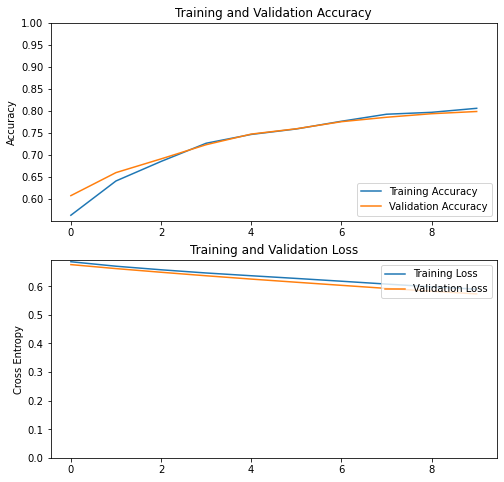

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

## Fine tuning

<img src="image/VGG3.png" width="500">

In [15]:
base_model.trainable = True

In [16]:
# base model의 layer 갯수를 확인
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [17]:
# Fine tuning을 시킬 기준 layer 선정
fine_tune_at = 15

# Fine tuning을 시킬 기준 layer 이전의 layer들을 모두 freezing
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

<img src="image/VGG2.png" width="500">

In [18]:
len(base_model.trainable_variables)

6

## Compile the model

In [19]:
#lr=0.0001
#lr=0.00002

In [20]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 7,079,937
Non-trainable params: 7,635,264
_________________________________________________________________


## Continue Train the model

In [22]:
history_fine = model.fit_generator(train_generator, 
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs, 
                                   workers=4,
                                   validation_data=validation_generator, 
                                   validation_steps=validation_steps)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 124 steps, validate for 31 steps
Epoch 1/10
124/124 [==============================] - 23s 189ms/step - loss: 0.3322 - accuracy: 0.8585 - val_loss: 0.2367 - val_accuracy: 0.9062
Epoch 2/10
124/124 [==============================] - 22s 178ms/step - loss: 0.2020 - accuracy: 0.9261 - val_loss: 0.1567 - val_accuracy: 0.9345
Epoch 3/10
124/124 [==============================] - 22s 178ms/step - loss: 0.1621 - accuracy: 0.9416 - val_loss: 0.1339 - val_accuracy: 0.9466
Epoch 4/10
124/124 [==============================] - 23s 183ms/step - loss: 0.1289 - accuracy: 0.9535 - val_loss: 0.1528 - val_accuracy: 0.9415
Epoch 5/10
124/124 [==============================] - 23s 184ms/step - loss: 0.1091 - accuracy: 0.9621 - val_loss: 0.1375 - val_accuracy: 0.9446
Epoch 6/10
124/124 [==============================] - 22s 179ms/step - loss: 0.0909 - accuracy: 0.9667 - val_loss: 0.1250 - val_accuracy: 0.9516
Epoch 7/10
124/124 [=================

## Learning curves 

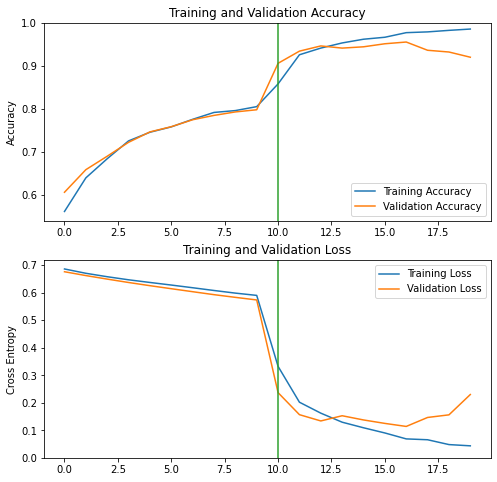

In [23]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([epochs,epochs], plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.plot([epochs,epochs], plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Loss')
plt.show()

# 본인만의 Transfer learning 모델을 만들어보세요

<span style="color:red">본인만의 창의적인 생각으로 수정한 내용을 적어주세요</span>

In [24]:
my_base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE, ######
                                               include_top=False, 
                                               weights='imagenet')

In [25]:
my_base_model.trainable = True

In [26]:
# base model의 layer 갯수를 확인
print("Number of layers in the base model: ", len(my_base_model.layers))

Number of layers in the base model:  19


- 레이어(fine_tune_at)를 설정해보세요 값 1~19

<img src="image/VGG3.png" width="500">

In [27]:
# Fine tuning을 시킬 기준 layer 선정
fine_tune_at = 10######

# Fine tuning을 시킬 기준 layer 이전의 layer들을 모두 freezing
for layer in my_base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [28]:
#학습 변수 개수 확인
len(my_base_model.trainable_variables)

12

In [29]:
my_model = tf.keras.Sequential([
  my_base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1, activation='sigmoid')
])

- 학습률(lr)을 설정해 보세요 값 0.001 보다 작게

In [30]:
my_model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=2e-6),######lr
              metrics=['accuracy'])

In [31]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 14,715,201
Trainable params: 12,979,713
Non-trainable params: 1,735,488
_________________________________________________________________


- epoch를 설정해보세요 값 num=1~15

In [32]:
##설정##
epochs = 10######
########
steps_per_epoch = train_generator.n // batch_size
                   #2000             //   #32       =  62
validation_steps = validation_generator.n // batch_size
                    #1000                     #32      = 31
my_history = my_model.fit_generator(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs, 
                              workers=4,
                              validation_data=validation_generator, 
                              validation_steps=validation_steps)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 248 steps, validate for 31 steps
Epoch 1/10
248/248 [==============================] - 48s 193ms/step - loss: 0.5492 - accuracy: 0.7424 - val_loss: 0.3876 - val_accuracy: 0.8438
Epoch 2/10
248/248 [==============================] - 46s 186ms/step - loss: 0.3151 - accuracy: 0.8808 - val_loss: 0.2440 - val_accuracy: 0.9083
Epoch 3/10
248/248 [==============================] - 46s 186ms/step - loss: 0.2160 - accuracy: 0.9221 - val_loss: 0.1718 - val_accuracy: 0.9395
Epoch 4/10
248/248 [==============================] - 46s 186ms/step - loss: 0.1679 - accuracy: 0.9389 - val_loss: 0.1510 - val_accuracy: 0.9415
Epoch 5/10
248/248 [==============================] - 46s 186ms/step - loss: 0.1422 - accuracy: 0.9499 - val_loss: 0.1354 - val_accuracy: 0.9486
Epoch 6/10
248/248 [==============================] - 46s 186ms/step - loss: 0.1158 - accuracy: 0.9614 - val_loss: 0.1234 - val_accuracy: 0.9496
Epoch 7/10
248/248 [=================

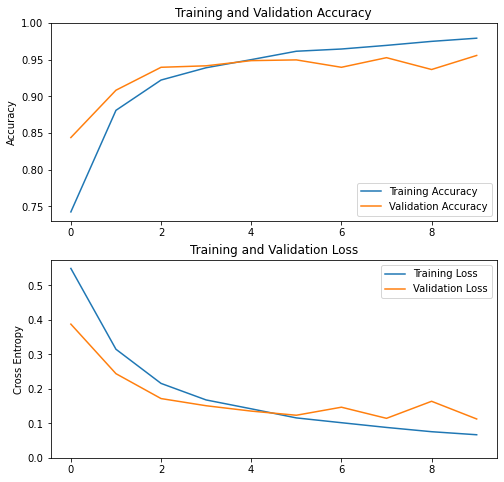

In [35]:
my_acc = my_history.history['accuracy']
my_val_acc = my_history.history['val_accuracy']

my_loss = my_history.history['loss']
my_val_loss = my_history.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(my_acc, label='Training Accuracy')
plt.plot(my_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(my_loss, label='Training Loss')
plt.plot(my_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()